# Chamber Forward Simulation

Comprehending particle dynamics within controlled environments is fundamental for the precise interpretation of experimental measurements. An aerosol chamber forward simulation is an approach employed to analyze and predict the behavior of particles under laboratory conditions. This method enables us to construct a virtual representation of the chamber dynamics, providing a platform to systematically examine the influence of different physical and chemical processes on aerosol populations. Specifically, we focus on three key processes: chamber aerosol dilution, particle coagulation, and wall loss (deposition). Each of these plays a pivotal role in shaping the size distribution of particles:

- **Chamber Aerosol Dilution**: Dilution refers to the reduction in particle concentration due to the introduction of clean air into the chamber. This process can lead to a decrease in the overall number of particles without altering the size distribution significantly. However, it can indirectly influence the dynamics of coagulation and deposition by changing the particle concentration.
- **Particle Coagulation**: Coagulation is the process where particles collide and stick together, forming larger particles. This leads to a shift in the size distribution towards larger sizes, reducing the number of smaller particles and increasing the average size of particles in the chamber. Coagulation is particularly significant for smaller particles due to their higher Brownian motion and likelihood of interaction.
- **Wall Loss** (Deposition): Wall loss occurs when particles deposit onto the walls of the chamber, removing them from the airborne population. This process preferentially affects larger particles due to their greater settling velocity and can lead to a decrease in the overall number of particles and a subtle shift in the size distribution towards smaller sizes.

We'll be running a simulation of a chamber experiment, and turn on/off each of these processes to see how they affect the size distribution of particles. We'll also be able to see how the size distribution changes over time as the experiment progresses.

The initial `particula` imports are next.

In [1]:
# In Colab uncomment the following command to install particula:
#!pip install particula[extra] --quiet
import numpy as np
import particula as par
from matplotlib import pyplot as plt

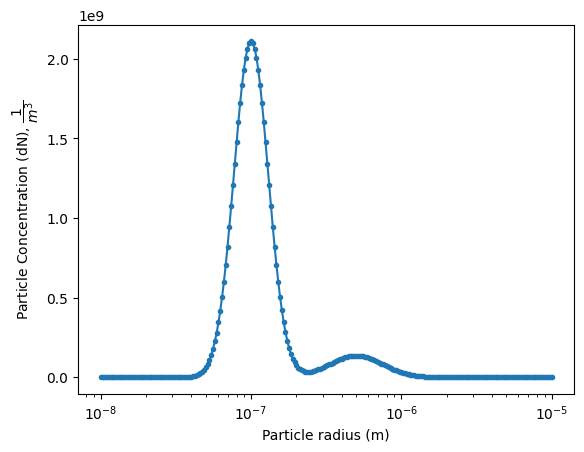

In [2]:
# Define initial simulation parameters
mode = np.array([100e-9, 500e-9])  # Median diameter of the particles in meters
geometric_standard_deviation = np.array(
    [1.3, 1.5]
)  # Geometric standard deviation of particle size distribution
number_in_mode = (
    np.array([5e4, 5e3]) * 1e6
)  # Number of particles in each mode  1/m^3


# define the radius bins for the simulation
radius_bins = np.logspace(-8, -5, 250)


# Create particle distribution using the defined parameters

concentration_pmf = par.particles.get_lognormal_pmf_distribution(
    x_values=radius_bins,
    mode=mode,
    geometric_standard_deviation=geometric_standard_deviation,
    number_of_particles=number_in_mode,
)


# plot the initial particle distribution
fig, ax = plt.subplots()
ax.plot(
    radius_bins, concentration_pmf, label="Initial distribution", marker="."
)
ax.set_xscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel(r"Particle Concentration (dN), $\dfrac{1}{m^{3}}$")
plt.show()

## Rates

With the initial concentration setup we can now get the rates of change for the distribution of particles. These come from the `dynamics` module, which contains the functions to calculate the rates of change for each process. The `dynamics` module contains the following functions:

- `dilution_rate`: Calculates the rate of change due to dilution.
- `coagulation_rate`: Calculates the rate of change due to coagulation.
- `wall_loss_rate`: Calculates the rate of change due to wall loss.

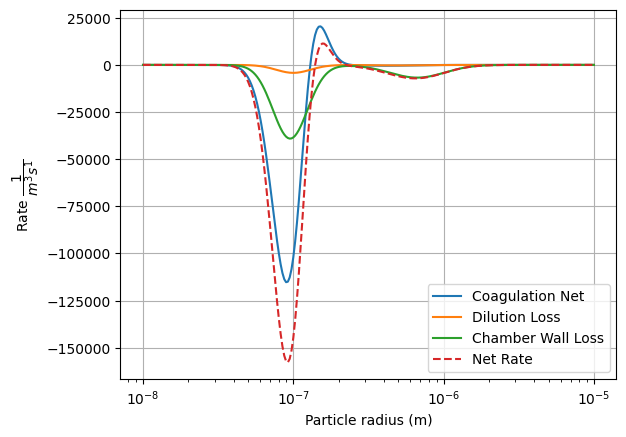

In [3]:
# coagulation rate

particle_mass = (
    4 / 3 * np.pi * radius_bins**3 * 1000
)  # mass of the particles in kg

kernel = np.asarray(
    par.dynamics.get_brownian_kernel_via_system_state(
        particle_radius=radius_bins,
        particle_mass=particle_mass,
        temperature=293.15,
        pressure=101325,
        alpha_collision_efficiency=1,
    ),
)
coagulation_loss = par.dynamics.get_coagulation_loss_rate_discrete(
    concentration=concentration_pmf,
    kernel=kernel,
)
coagulation_gain = par.dynamics.get_coagulation_gain_rate_discrete(
    radius=radius_bins,
    concentration=concentration_pmf,
    kernel=kernel,
)
coagulation_net = coagulation_gain - coagulation_loss

# dilution rate
dilution_coefficent = par.dynamics.get_volume_dilution_coefficient(
    volume=1,  # m^3
    input_flow_rate=2 * 1e-6,  # m^3/s
)
dilution_loss = par.dynamics.get_dilution_rate(
    coefficient=dilution_coefficent,
    concentration=concentration_pmf,
)

# wall loss rate
chamber_wall_loss_rate = par.dynamics.get_rectangle_wall_loss_rate(
    wall_eddy_diffusivity=0.1,
    particle_radius=radius_bins,
    particle_density=1000,
    particle_concentration=concentration_pmf,
    temperature=293.15,
    pressure=101325,
    chamber_dimensions=(1, 1, 1),  # m
)

# plot rates
fig, ax = plt.subplots()
ax.plot(
    radius_bins,
    coagulation_net,
    label="Coagulation Net",
)
ax.plot(
    radius_bins,
    dilution_loss,
    label="Dilution Loss",
)
ax.plot(
    radius_bins,
    chamber_wall_loss_rate,
    label="Chamber Wall Loss",
)
ax.plot(
    radius_bins,
    coagulation_net + dilution_loss + chamber_wall_loss_rate,
    label="Net Rate",
    linestyle="--",
)
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel(r"Rate $\dfrac{1}{m^{3} s^{1}}$")
ax.grid()
plt.legend()
plt.show()

## For-loop Simulation

With the an example of how to calculate the rates of change for each process, we can now simulate the chamber experiment. We'll iterate over a series of time steps and calculate the change in particle concentration due to each process. This is an iterative process where we update the particle distribution at each time step based on the rates of change calculated for dilution, coagulation, and wall loss. The rates are also updated at each time step to account for the changing particle concentration within the chamber.

In [4]:
# time steps
time_array = np.linspace(start=0, stop=3600, num=1000)
dt = time_array[1] - time_array[0]

# create a matrix to store the particle distribution at each time step
concentration_matrix = np.zeros((len(time_array), len(radius_bins)))
coagulation_net_matrix = np.zeros((len(time_array), len(radius_bins)))
dilution_loss_matrix = np.zeros((len(time_array), len(radius_bins)))
chamber_wall_loss_rate_matrix = np.zeros((len(time_array), len(radius_bins)))

# set the initial concentration
concentration_matrix[0, :] = concentration_pmf

kernel = np.asarray(
    par.dynamics.get_brownian_kernel_via_system_state(
        particle_radius=radius_bins,
        particle_mass=particle_mass,
        temperature=293.15,
        pressure=101325,
        alpha_collision_efficiency=1,
    )
)
# iterate over the time steps
for i in range(1, len(time_array)):
    # calculate the coagulation rate
    coagulation_loss = par.dynamics.get_coagulation_loss_rate_discrete(
        concentration=concentration_matrix[i - 1, :],
        kernel=kernel,
    )
    coagulation_gain = par.dynamics.get_coagulation_gain_rate_discrete(
        radius=radius_bins,
        concentration=concentration_matrix[i - 1, :],
        kernel=kernel,
    )
    coagulation_net = coagulation_gain - coagulation_loss

    # calculate the dilution rate
    dilution_coefficent = par.dynamics.get_volume_dilution_coefficient(
        volume=1,  # m^3
        input_flow_rate=2 * 1e-6,  # m^3/s
    )
    dilution_loss = par.dynamics.get_dilution_rate(
        coefficient=dilution_coefficent,
        concentration=concentration_matrix[i - 1, :],
    )

    # calculate the wall loss rate
    chamber_wall_loss_rate = par.dynamics.get_rectangle_wall_loss_rate(
        wall_eddy_diffusivity=0.1,
        particle_radius=radius_bins,
        particle_density=1000,
        particle_concentration=concentration_matrix[i - 1, :],
        temperature=293.15,
        pressure=101325,
        chamber_dimensions=(1, 1, 1),  # m
    )

    # update the concentration matrix
    concentration_matrix[i, :] = (
        concentration_matrix[i - 1, :]
        + (coagulation_net + dilution_loss + chamber_wall_loss_rate) * dt
    )

    # update the rate matrices
    coagulation_net_matrix[i, :] = coagulation_net
    dilution_loss_matrix[i, :] = dilution_loss
    chamber_wall_loss_rate_matrix[i, :] = chamber_wall_loss_rate

print("Done")

Done


## Visualization of Particle Size Distribution Over Time

In our chamber simulation, the output solution is a matrix representing the evolution of particle size distribution over time. Specifically, the solution is a 500x100 matrix where each row corresponds to a specific particle size (500 size bins in total), and each column represents the particle distribution at a given time point (100 time steps in total).

The semi-logarithmic plot visualizes how the particle size distribution changes over the course of the simulation. We are focusing on three specific time points to illustrate these dynamics:

- **Initial Distribution**: This is the distribution at the beginning of the simulation (t=0). It sets the baseline for how particles are initially distributed across different sizes.
- **Mid-Time Distribution**: Represents the distribution at a midpoint in time (here, at the 50th time step out of 100). This snapshot provides insight into the evolution of the distribution as particles undergo processes like coagulation, dilution, and wall loss.
- **Final Distribution**: Shows the distribution at the end of the simulation (at the 100th time step). It indicates the final state of the particle sizes after all the simulated processes have taken place over the full time course.

By comparing these three distributions, we can observe and analyze how the particle sizes have coalesced, dispersed, or shifted due to the underlying aerosol dynamics within the chamber.

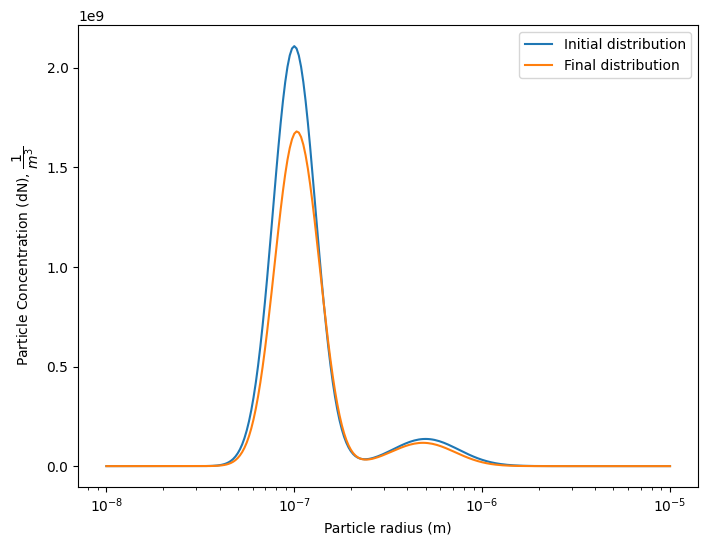

In [5]:
# Plotting the simulation results
# Adjusting the figure size for better clarity
fig, ax = plt.subplots(1, 1, figsize=[8, 6])

# plot the initial particle distribution
ax.plot(
    radius_bins,
    concentration_matrix[0, :],
    label="Initial distribution",
)
# plot the final particle distribution
ax.plot(
    radius_bins,
    concentration_matrix[-1, :],
    label="Final distribution",
)
ax.set_xscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel(r"Particle Concentration (dN), $\dfrac{1}{m^{3}}$")
plt.legend()
plt.show()

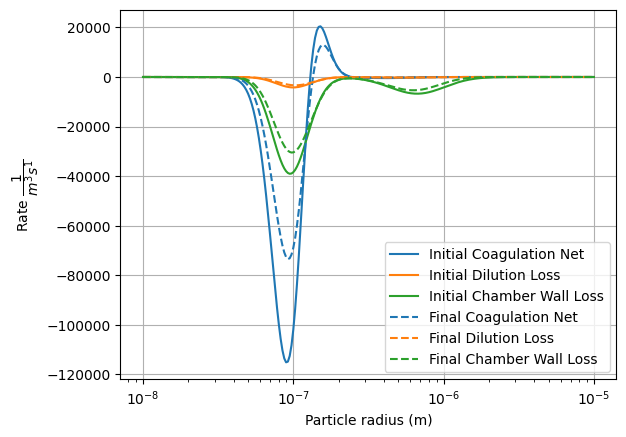

In [6]:
# plot the Initial and Final rates
fig, ax = plt.subplots()
ax.plot(
    radius_bins,
    coagulation_net_matrix[1, :],
    color="tab:blue",
    label="Initial Coagulation Net",
)
ax.plot(
    radius_bins,
    dilution_loss_matrix[1, :],
    color="tab:orange",
    label="Initial Dilution Loss",
)
ax.plot(
    radius_bins,
    chamber_wall_loss_rate_matrix[1, :],
    color="tab:green",
    label="Initial Chamber Wall Loss",
)
ax.plot(
    radius_bins,
    coagulation_net_matrix[-1, :],
    color="tab:blue",
    label="Final Coagulation Net",
    linestyle="--",
)
ax.plot(
    radius_bins,
    dilution_loss_matrix[-1, :],
    color="tab:orange",
    label="Final Dilution Loss",
    linestyle="--",
)
ax.plot(
    radius_bins,
    chamber_wall_loss_rate_matrix[-1, :],
    color="tab:green",
    label="Final Chamber Wall Loss",
    linestyle="--",
)
ax.set_xscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel(r"Rate $\dfrac{1}{m^{3} s^{1}}$")
ax.grid()
plt.legend()
plt.show()

## Takeaways

In this notebook, we conducted a series of simulations to study the behavior of aerosol particles within a controlled chamber environment. Our objective was to understand how different processes — namely coagulation, dilution, and wall loss — individually and collectively influence the size distribution of particles over time.

Our simulations revealed several key findings:

- **Coagulation Alone**: When only coagulation was considered, the particle size distribution shifted towards larger particles as expected, since smaller particles tend to combine. However, this view was incomplete as it did not account for other loss mechanisms.
- **Importance of Wall Loss**: The inclusion of wall loss in the simulations proved to be significant. Wall loss, or deposition, especially affected the larger particles due to their higher probability of contact with the chamber walls. This process led to a noticeable reduction in the number concentration of particles, altering the peak and width of the size distribution.
- **Combined Processes**: By simulating a combination of processes, we observed a more complex and realistic representation of particle dynamics. The coagulation plus dilution scenario showed a lower overall concentration across all sizes, while adding wall loss further decreased the number concentration and altered the distribution shape, underscoring the importance of including wall loss in chamber simulations.

The comparison between the different scenarios highlighted that coagulation alone could not fully explain the experimental observations. The absence of wall loss from the simulation would lead to discrepancies when comparing with empirical data, as wall loss is a critical process in chamber dynamics.